In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

# 13C4 Asn uptake in 143B cells
In this notebook I will process and plot data from an experiment were I quantified amino acid uptake from media over time to determine the total aspartate consumption flux.



### How to calculate flux
For cell count ($y$), the cell counts over time is defined as an exponential function ($y(t)$) with proliferation rate $K$ and cell count at $t=0$ being $y_0$:
$$
y(t) = y_0 2^{K t}
$$

If we assume that amino acid uptake into a cell is constant, the uptake rate (also called influx) can be defined as the total molar uptake over at time range divided by the total area under the cell count curve over the same time range.

Formally, with $F_i$ being the influx and $n(t)$ being the molar quantity of a compound $i$, and $t_1$ and $t_2$ first and second timepoint, respectively, defining the time range:
$$
F_i = \frac{n_i(t_1) - n_i(t_2)}{\int_{t_1}^{t_2} y(t) dt}
$$

Using $\Delta$ to indicate we can simplify the above:
$$
F_i = \frac{\Delta n_i}{\int_{t_1}^{t_2} y(t) dt} = \frac{\Delta n_i}{\frac{y_0 2^{K t_2}}{K\ \text{ln}(2)} - \frac{y_0 2^{K t_1}}{K\ \text{ln}(2)}} = \frac{\Delta n_i}{\frac{y_0 (2^{K t_2} - 2^{K t_1})}{K\ \text{ln}(2)}}
$$
The denominator is equal to the area under the cell count curve over the same time range ($t_1$ to $t_2$), this is sometimes referred to as "cell hours" becuase of its unit is time, typically in hours.

Using cell hours it is possible to calculate the molar quantity taken up per cell per hour, typically as: $\frac{\text{fmol}}{\text{cell}\times h}$.
However, this makes it hard to compare accross cell lines because of variability in cell size. To fix this, simply redefine the problem from integrating the area under the cell count curve to the area under the volumne increase curve.
This is trivial using a volume per cell multiplier ($V_c$):
$$
V(t) = y(t) V_c = V_c y_0 2^{t K}
$$

Since $V_c$ is indenpendent of time, it is not integrated and we get:
$$
F_i = \frac{\Delta n_i}{\frac{V_c y_0 (2^{K t_2} - 2^{K t_1})}{K\ \text{ln}(2)}}
$$

Since $V_c$ is a volume, we have a denominator with typical unit of $\frac{L}{h}$.
We could call this "volume hours", and dividing the molar quantity onto this we get the typical unit of $\frac{\text{mM}}{h}$ which is comparable accross cell lines with different sizes.

Sometimes it can be usefull to convert the influx of a compound to the intracellular concentration of the compound.
In doing this we assume that the influxed compound is passively accumulating inside the cell and this can be a reasonable assumption when looking at for instance essential amino acids.
For example take leucine, by adding the amount of free leucine with that bound in protein it should correspond to that being taken up through influx as it is neither synthesized nor broken down.
To convert flux to cell concentration for compound $i$ observe the following rearrangement of above:
$$
F_i = K\ \text{ln}(2) \frac{\Delta n_i}{V_c y_0 (2^{K t_2} - 2^{K t_1})}
$$

The fraction is the molar quantity of consumed compound $i$ divided by the accumulation of cell volume i.e. the intracellular concentration of compound $i$ ($C_i$).
Thus we have:
$$
F_i = K\ \text{ln}(2) C_i => C_i = \frac{F_i}{K\ \text{ln}(2)}
$$



In [2]:
AAcode = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Asparagine-13C4': '*Asn',
    'Aspartate': 'Asp',
    'Glutamate': 'Glu',
    'Glutamine': 'Gln',
    'Glycine': 'Gly',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine': 'Val'}

AA_protMW = {
'Aspartate': 115.08742,
'Asparagine': 114.10262,
'Arginine': 156.18572,
'Glycine': 57.05132,
'Glutamate': 129.11402,
'Tyrosine': 163.17322,
'Histidine': 137.13932,
'Glutamine': 128.12922,
'Serine': 87.07732,
'Proline': 97.11522,
'Threonine': 101.10392,
'Tryptophan': 186.20992,
'Lysine': 128.17232,
'Methionine': 131.19602,
'Leucine': 113.15762,
'Cysteine': 103.14292,
'Valine': 99.13102,
'Phenylalanine': 147.17382,
'Isoleucine': 113.15762,
'Alanine': 71.07792
}

In [3]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    conc = piece_wise_fit_metab[k](response_ratio)
    estimator = 'intrapolation'
    if 0 in k:
        estimator = 'extrapolation under'
    elif np.inf in k:
        estimator = 'extrapolation over'
    return(conc, estimator)

### Calculate quantities and fluxes

In [4]:
### Read quantification function ###
# dict_pickle_fnam = 'input/AA-quant_oct_20.pickle'
dict_pickle_fnam = 'input/AA-quant_oct_20_M1.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_AA = pickle.load(handle)
# Merge the two quantitation dictionaries:
piece_wise_fit_quant = {**piece_wise_fit_AA}
# Quant labelled Asn the same:
piece_wise_fit_quant['Asparagine-13C4 pos'] = piece_wise_fit_quant['Asparagine pos']

### Read measurements ###
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('input/Asn_uptake-to-flux_oct20.xlsx', sheet_name=None)
annotation_df = pd.read_excel('input/annotations.xlsx')
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k])
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Area'] / metab_dict_mes[k]['ISTD Response']
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'].fillna(0).replace(np.inf, 0)
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-2]+'_'+fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Filename', 'Type', 'RT', 'Height', 'S/N', 'Sample ID', 'ISTD Response'], axis=1)

### Impute concentration and add to metabolite dataframe ###
rr_mes = dict() # for plotting 
imp_conc_mes = dict() # for plotting
for metab in metab_names_mes[:]:
    # Assign imputed concentration:
    if metab in piece_wise_fit_quant:
        conc_list = list()
        estimator_list = list()
        for rr in metab_dict_mes[metab]['Response Ratio'].values:
            conc, estimator = impute_conc(piece_wise_fit_quant[metab], rr)
            conc_list.append(conc)
            estimator_list.append(estimator)
        metab_dict_mes[metab]['imputed_sample_conc'] = conc_list
        metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list

        # Extract data for plotting:
        if metab in rr_mes:
            rr_mes[metab].extend(list(metab_dict_mes[metab]['Response Ratio'].values))
            imp_conc_mes[metab].extend(list(metab_dict_mes[metab]['imputed_sample_conc'].values))
        else:
            rr_mes[metab] = list(metab_dict_mes[metab]['Response Ratio'].values)
            imp_conc_mes[metab] = list(metab_dict_mes[metab]['imputed_sample_conc'].values)

In [5]:
# Convert to media concentration and flux:
for metab in metab_names_mes:
    mask = metab_dict_mes[metab]['intracellular'] == False
    if metab in piece_wise_fit_quant:
        metab_dict_mes[metab]['undil_sample_conc'] = 0
        metab_dict_mes[metab].loc[mask, 'undil_sample_conc'] = metab_dict_mes[metab][mask]['imputed_sample_conc'] / metab_dict_mes[metab][mask]['dilution_factor']
        metab_dict_mes[metab]['pmol'] = 0
        metab_dict_mes[metab].loc[mask, 'pmol'] = metab_dict_mes[metab][mask]['undil_sample_conc'] * metab_dict_mes[metab][mask]['Media_vol']
        blank_pmol = metab_dict_mes[metab][metab_dict_mes[metab]['Time'] == 0]['undil_sample_conc'] * metab_dict_mes[metab][metab_dict_mes[metab]['Time'] == 0]['Media_vol_t0']
        metab_dict_mes[metab]['nmol_depleted'] = 0
        mask_10 = metab_dict_mes[metab]['Time'] == 10
        mask_24 = metab_dict_mes[metab]['Time'] == 24
        metab_dict_mes[metab].loc[mask_10&mask, 'nmol_depleted'] = (blank_pmol.values - metab_dict_mes[metab][mask_10&mask]['pmol'].values) * 1e-3
        metab_dict_mes[metab].loc[mask_24&mask, 'nmol_depleted'] = (blank_pmol.values - metab_dict_mes[metab][mask_24&mask]['pmol'].values) * 1e-3
        # Influx in mM/h:
        metab_dict_mes[metab]['Influx'] = 0
        metab_dict_mes[metab].loc[mask, 'Influx'] = metab_dict_mes[metab][mask]['nmol_depleted'] / metab_dict_mes[metab][mask]['vol_hour'] * 1e-6
#        if metab == 'Asparagine-13C4 pos':
#            metab_dict_mes[metab].loc[mask, 'Influx'] = metab_dict_mes[metab].loc[mask, 'Influx'] / metab_dict_mes[metab].loc[mask, 'Asn_X'] - metab_dict_mes['Asparagine pos'].loc[mask, 'Influx']
        # Total accumulated concentration:
        metab_dict_mes[metab]['Total conc.'] = 0
        metab_dict_mes[metab].loc[mask, 'Total conc.'] = metab_dict_mes[metab][mask]['nmol_depleted'] / metab_dict_mes[metab][mask]['vol_accum'] * 1e-6
#        if metab == 'Asparagine-13C4 pos':
#            metab_dict_mes[metab].loc[mask, 'Total conc.'] = metab_dict_mes[metab].loc[mask, 'Total conc.'] / metab_dict_mes[metab].loc[mask, 'Asn_X']

### Extract all metabolites for quantification - imputed conc. ###
df_imp = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'imputed_sample_conc', 'imputed_sample_estimator', 'undil_sample_conc', 'pmol', 'nmol_depleted', 'Influx', 'Total conc.', 'Asn_X'], axis=1)
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df_imp['Sample_name']))
        df_imp[metab] = metab_dict_mes[metab]['imputed_sample_conc']
# Save data in Excel file (mM):
df_imp.to_excel('output/imputed-conc.xlsx', index=False)

In [6]:
### Extract all metabolites for quantification - flux ###
df_flux = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'imputed_sample_conc', 'imputed_sample_estimator', 'undil_sample_conc', 'pmol', 'nmol_depleted', 'Influx', 'dilution_factor', 'vol_hour', 'Media_vol', 'vol_accum', 'Total conc.', 'Media_vol_t0'], axis=1)
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df_flux['Sample_name']))
        df_flux[metab] = metab_dict_mes[metab]['Influx']

# Asn consumption flux towards protein synthesis:
df_flux['J_Asn_prot'] = -df_flux['Asparagine-13C4 pos'] / df_flux['Asn_X']
# Asn efflux, if no asparagine in media:
df_flux['J_allAsn_out'] = df_flux['Asparagine pos'] / (1 - df_flux['Asn_X'])
# Save data in Excel file (mM/h):
df_flux.to_excel('output/influx.xlsx', index=False)

In [7]:
### Extract all metabolites for quantification - accumulated cell conc. ###
df_acc = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'imputed_sample_conc', 'imputed_sample_estimator', 'undil_sample_conc', 'pmol', 'nmol_depleted', 'Influx', 'dilution_factor', 'vol_hour', 'Media_vol', 'vol_accum', 'Total conc.', 'Media_vol_t0'], axis=1)
for metab in metab_names_mes:
    if metab in piece_wise_fit_quant:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df_acc['Sample_name']))
        df_acc[metab] = metab_dict_mes[metab]['Total conc.']

# Asn accumulated cell conc. towards protein synthesis:
df_acc['Asn_prot'] = -df_acc['Asparagine-13C4 pos'] / df_acc['Asn_X']
# Asn accumulated cell conc. towards efflux, if no asparagine in media:
df_acc['allAsn_out'] = df_acc['Asparagine pos'] / (1 - df_acc['Asn_X'])
# Save data in Excel file (mM):
df_acc.to_excel('output/total-cell-conc.xlsx', index=False)

In [8]:
# Export intracellular Asn labeling to Excel:
asn_df = metab_dict_mes['Asparagine pos'].loc[:, ['Sample_name', 'intracellular', 'Area']]
asn_df['Metab'] = 'Asn'

asn_l_df = metab_dict_mes['Asparagine-13C4 pos'].loc[:, ['Sample_name', 'intracellular', 'Area']]
asn_l_df['Metab'] = 'Asn_13C4'

asn_df = pd.concat([asn_df, asn_l_df])
asn_df['Replicate'] = [int(sn.split('_')[-1]) for sn in asn_df['Sample_name']]
asn_df_intra = asn_df.loc[asn_df['intracellular'], ['Replicate', 'Metab', 'Area']].copy()

# Save data in Excel file:
asn_df_intra.to_excel('output/asn_intra_labelling.xlsx', index=False)

### Plot data - influx
Note that \*Asn is equivalent to net asparagine flux into cell material i.e. ASNS flux if asparagine could not be taken up or released from the cell.

In [9]:
# Rename to three letter amino acid code,
# Sort according to highest influx at 25 h
df_flux.columns = [v.split()[0] for v in df_flux.columns.values]
df_flux = df_flux.rename(columns=AAcode)
# Sort:
df_mean = df_flux.groupby(['Time', 'intracellular']).mean(numeric_only=True).reset_index()
col_sele = df_mean.columns.values[1:]
sort_mask = df_mean.loc[1, col_sele].sort_values(ascending=False).index.values
sort_mask = np.concatenate([['Sample_name', 'Time'], sort_mask])
df_sort = df_flux.loc[:, sort_mask]
df_sort['Replicate'] = [int(sn.split('_')[-1]) for sn in df_sort['Sample_name']]
df_sort = df_sort.drop(columns='Sample_name')
# Remove t=0:
time_mask = (df_sort['Time'] > 0) & (df_sort['intracellular'] == False)
df_sort = df_sort[time_mask]
# Flatten for plotting:
df_melt = df_sort.melt(id_vars=['Time', 'intracellular', 'Replicate'], var_name='Amino acid', value_name='Flux')

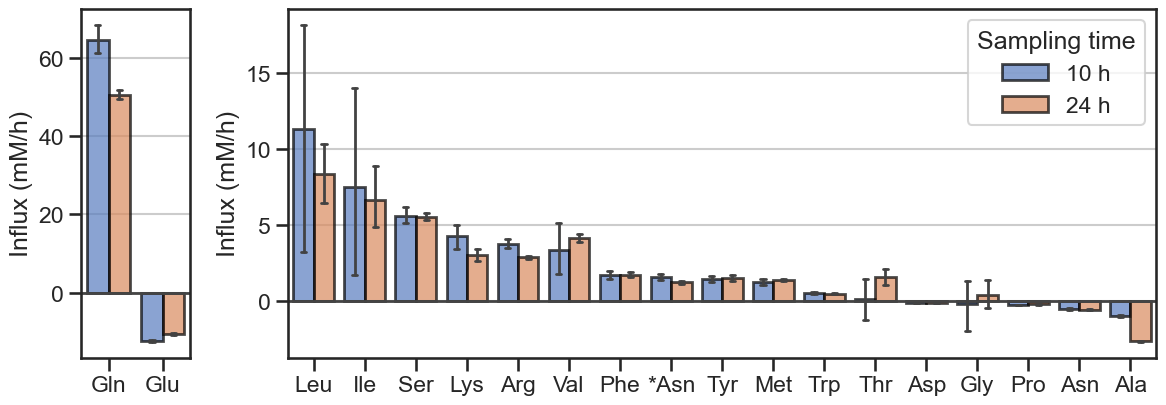

In [10]:
### Plot the influx ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.4), gridspec_kw={'width_ratios': [1, 8]})

# Small plot for Gln/Glu:
mask = df_melt['Amino acid'].isin(['Gln', 'Glu'])
g1 = sns.barplot(ax=ax1, x="Amino acid", y="Flux", hue="Time", data=df_melt[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Influx (mM/h)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)

# Plot the all other AAs:
mask2 = (df_melt['intracellular'] == False) & (df_melt['Amino acid'].isin(list(AAcode.values())))
g2 = sns.barplot(ax=ax2, x="Amino acid", y="Flux", hue="Time", data=df_melt[~mask&mask2], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax2.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g2.grid(True, axis='y')
g2.set_ylabel('Influx (mM/h)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=0);
#g2.set_ylim([-1.4, 5.6])
#g2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Add legend:
old_legend = g2.legend_
handles = old_legend.legend_handles
labels = ['10 h', '24 h']
title = 'Sampling time'
g2.legend(handles, labels, title=title);

# Show/save:
fig.tight_layout()
fig.savefig('output/influx.pdf')

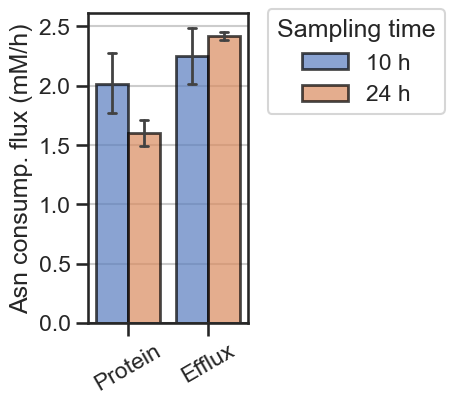

In [11]:
### Plot the Asn consumption flux ###
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4.4))

mask = (df_melt['Amino acid'].isin(['J_Asn_prot', 'J_allAsn_out']))
df_plot = df_melt[mask].copy()
df_plot['Flux'] *= -1
df_plot['Amino acid'] = df_plot['Amino acid'].replace({'J_Asn_prot': 'Protein', 'J_allAsn_out': 'Efflux'})
g1 = sns.barplot(ax=ax1, x="Amino acid", y="Flux", hue="Time", data=df_plot, capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Asn consump. flux (mM/h)');
g1.set_xlabel('');
g1.set_xticklabels(g1.get_xticklabels(), rotation=30)

# Add legend:
old_legend = g1.legend_
handles = old_legend.legend_handles
labels = ['10 h', '24 h']
title = 'Sampling time'
g1.legend(handles, labels, title=title, loc='upper left', bbox_to_anchor=(1.05, 1.05));

# Show/save:
fig.tight_layout()
fig.savefig('output/Asn_flux.pdf')

In [12]:
# Save data in Excel file:
df_melt.loc[~df_melt['intracellular'], ['Replicate', 'Time', 'Amino acid', 'Flux']].to_excel('output/influx_flat.xlsx', index=False)

### Plot data - total cell concentration

In [13]:
# Rename to three letter amino acid code,
# Sort according to highest conc. at 25 h
df_acc.columns = [v.split()[0] for v in df_acc.columns.values]
df_acc = df_acc.rename(columns=AAcode)
# Sort:
df_mean = df_acc.groupby(['Time', 'intracellular']).mean(numeric_only=True).reset_index()
col_sele = df_mean.columns.values[1:]
sort_mask = df_mean.loc[1, col_sele].sort_values(ascending=False).index.values
sort_mask = np.concatenate([['Time'], sort_mask])
df_sort = df_acc.loc[:, sort_mask]
# Remove t=0:
time_mask = (df_sort['Time'] > 0) & (df_sort['intracellular'] == False)
df_sort = df_sort[time_mask]
# Flatten for plotting:
df_melt = df_sort.melt(id_vars=['Time', 'intracellular'], var_name='Amino acid', value_name='ACC')

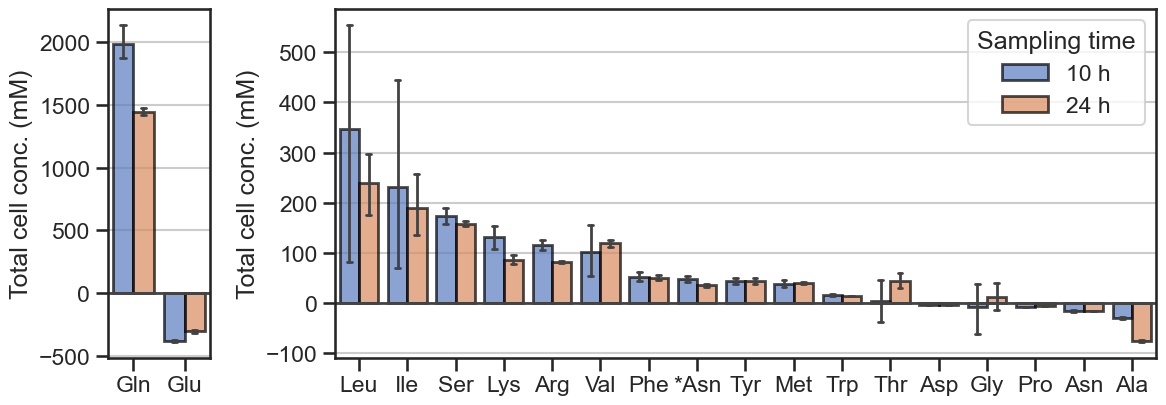

In [14]:
### Plot the influx ###
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.4), gridspec_kw={'width_ratios': [1, 8]})

# Small plot for Gln/Glu:
mask = df_melt['Amino acid'].isin(['Gln', 'Glu'])
g1 = sns.barplot(ax=ax1, x="Amino acid", y="ACC", hue="Time", data=df_melt[mask], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax1.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=0)

# Plot the all other AAs:
mask2 = (df_melt['intracellular'] == False) & (df_melt['Amino acid'].isin(list(AAcode.values())))
g2 = sns.barplot(ax=ax2, x="Amino acid", y="ACC", hue="Time", data=df_melt[~mask&mask2], capsize=.1, errwidth=2, edgecolor='black', linewidth=2, alpha=0.7)
ax2.axhline(y=0, linestyle='-', zorder=1, linewidth=2, color='#444444')
g2.grid(True, axis='y')
g2.set_ylabel('Total cell conc. (mM)');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=0);
#g2.set_ylim([-1.4, 5.6])
#g2.yaxis.set_major_locator(ticker.MultipleLocator(1))

# Add legend:
old_legend = g2.legend_
handles = old_legend.legend_handles
labels = ['10 h', '24 h']
title = 'Sampling time'
g2.legend(handles, labels, title=title);

# Show/save:
fig.tight_layout()
fig.savefig('output/total-cell-conc.pdf')